<a href="https://colab.research.google.com/github/poperskop/Bitcoin-forecast-LSTM/blob/main/bitcoin_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pytorch-lightning -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 40.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys

warnings.filterwarnings('ignore')
torch.manual_seed(42)

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [54]:
df = pd.read_csv('coin_Bitcoin.csv')
df = df[['Date', 'Open']]
df = df.set_index(['Date'])
df.head()

,Open
Date,
2013-04-29 23:59:59,134.444000
2013-04-30 23:59:59,144.000000
2013-05-01 23:59:59,139.000000
2013-05-02 23:59:59,116.379997
2013-05-03 23:59:59,106.250000


In [55]:
df.describe()

,Open
count,2991.000000
mean,6700.146240
std,11288.043736
min,68.504997
25%,430.445496
50%,2269.889893
75%,8569.656494
max,63523.754869


In [56]:
df.isna().sum()

,0
Open,0


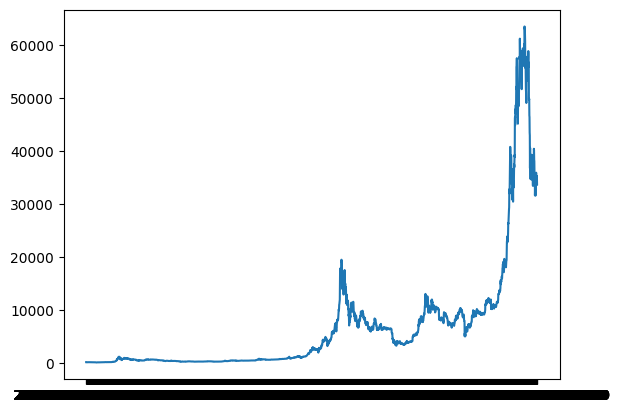

In [57]:
plt.plot(df.index, df.Open)

In [8]:
window = 10
horizon = 3

df['target'] = df.Open.shift(horizon)

for i in range(-window, 0):
  df[f'open {i}'] = df.Open.shift(i)

df.dropna(inplace=True)
df.drop(['Open'], inplace=True, axis=1)
df.head()

,target,open -10,open -9,open -8,open -7,open -6,open -5,open -4,open -3,open -2,open -1
Date,,,,,,,,,,,
2013-05-02 23:59:59,134.444000,115.639999,117.699997,112.799004,113.199997,109.599998,112.250000,115.980003,112.900002,98.099998,106.250000
2013-05-03 23:59:59,144.000000,114.820000,115.639999,117.699997,112.799004,113.199997,109.599998,112.250000,115.980003,112.900002,98.099998
2013-05-04 23:59:59,139.000000,117.980003,114.820000,115.639999,117.699997,112.799004,113.199997,109.599998,112.250000,115.980003,112.900002
2013-05-05 23:59:59,116.379997,111.400002,117.980003,114.820000,115.639999,117.699997,112.799004,113.199997,109.599998,112.250000,115.980003
2013-05-06 23:59:59,106.250000,114.220001,111.400002,117.980003,114.820000,115.639999,117.699997,112.799004,113.199997,109.599998,112.250000


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df = scaler.fit_transform(df)
print(type(df))

<class 'numpy.ndarray'>


RNN

In [10]:
class Df(Dataset):
    def __init__(self, dataframe, device):
        self.data = dataframe
        self.shape = self.data.shape
        print(self.shape)

    def __getitem__(self, index):
        feature = self.data[index, 1:]
        target = self.data[index, 0]
        return {'features':torch.tensor(feature, dtype=torch.float32).view(-1, 1).to(device),
                'targets': torch.tensor(target, dtype=torch.float32).to(device)
                }

    def __len__(self):
        return len(self.data)


In [11]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, random_state=42, test_size=0.2)
print(train_data.shape, test_data.shape)

(2382, 11) (596, 11)


In [12]:
train_storage = Df(train_data, device)
train_loader = DataLoader(train_storage, batch_size=10, shuffle=True)

test_storage = Df(test_data, device)
test_loader = DataLoader(test_storage, batch_size=1, shuffle=False)

(2382, 11)
(596, 11)


In [49]:
class SimpleRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    self.rnn1 = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.drop1 = nn.Dropout(p=0.2, inplace=False)
    self.norm2 = nn.LayerNorm([hidden_size])
    self.dense = nn.Linear(hidden_size, 1)

  def forward(self, x, test=False):
    x, _ = self.rnn1(x)
    x = self.norm2(x[:, -1, :])
    # x = self.drop1(x)
    x = self.dense(x)
    return x


In [33]:
import pytorch_lightning as pl

# define the LightningModule
class ForecastModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss = nn.MSELoss()

    def training_step(self, batch):
        # training_step defines the train loop.
        # it is independent of forward
        x = batch['features']
        y = batch['targets']
        pred = self.model(x).flatten()
        loss = self.loss(y, pred)
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch):
        self.model.eval()
        x = batch['features']
        y = batch['targets']
        pred = self.model(x).flatten()
        test_loss = self.loss(y, pred)
        self.log("test_loss", test_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [50]:
basic_model = SimpleRNN(1, 8)
model = ForecastModel(basic_model)
trainer = pl.Trainer(limit_train_batches=100, max_epochs=10)
trainer.fit(model=model, train_dataloaders=train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | SimpleRNN | 377    | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
377       Trainable params
0         Non-trainable params
377       Total params
0.002     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [51]:
trainer.test(model=model, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0005834666080772877   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0005834666080772877}]

In [52]:
with torch.inference_mode():
  preds = trainer.model.model(torch.tensor(df[:, 1:]).float().view(-1, window, 1)).numpy()
  y = df[:, 0]

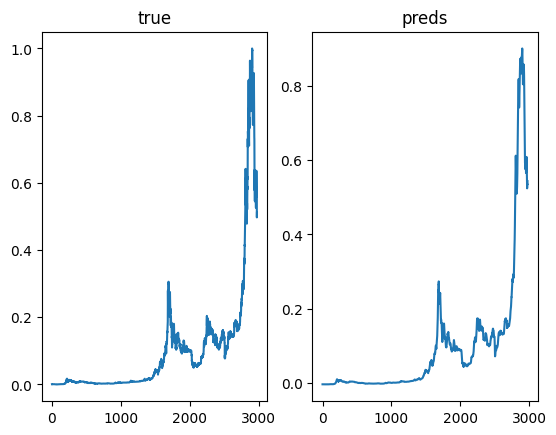

In [53]:
figure, axis = plt.subplots(1, 2)
axis[0].plot(y)
axis[0].set_title("true")
axis[1].plot(preds)
axis[1].set_title("preds")

plt.show()